In [1]:
import csv
import json
import os
import glob
import urllib
import itertools

import pandas as pd
import matplotlib.pyplot as plt

## Subcontracts

In [2]:
# Downloads contract json files and loads it into DATA

if not os.path.exists("data"):
    os.makedirs("data")

if not os.path.exists("csv"):
    os.makedirs("csv")    
    
for url in (
    "https://techinquiry.org/SiliconValley-Military/subcontracts/microsoft_cloud.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/microsoft_noncloud.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/amazon.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/google.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/facebook.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/nvidia.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/twitter.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/palantir.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/ida.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/mitre.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/johns_hopkins.json"
):
    
    path = os.path.join('./data/', url.split('/')[-1])

    if not os.path.isfile(path):
        urllib.request.urlretrieve(url, path)

DATA = {}

for path in glob.glob('./data/*.json'):
    company_name = os.path.splitext(os.path.basename(path))[0]
    
    with open(path, 'r') as f:
        if company_name in ["google", "amazon", "facebook", "microsoft_cloud", "microsoft_noncloud", "twitter"]:
            DATA[company_name] = json.load(f)

In [3]:
# flatten data in to map of company name to list of contracts
# calculates "passthrough_amount" using the "estimated_passthrough_rate"

def normalize_agency(x):
        if x[0:3] == 'DHS':
            return 'DHS'
        elif x[0:7] == 'Defense':
            return 'Defense'
        elif x[0:7] == 'Justice':
            return 'Justice'
        elif x == 'State':
            return 'State'
        else:
            return 'Other'


CONTRACTS = {}

for company in DATA.keys():
    company_contracts = []
    
    for intermediary in DATA[company]:
        for agency in DATA[company][intermediary]:
            for contract in DATA[company][intermediary][agency]:

                # json data uses two different keys -- mistake in original data?
                if "estimated_passthrough_percent" in contract:
                    passthrough_key = "estimated_passthrough_percent"
                else:
                    passthrough_key = "estimated_passthrough_rate"
                                
                company_contracts.append(
                    contract | 
                    { "intermediary": intermediary, "agency":  agency, "agency_normalized": normalize_agency(agency) } |
                    { "passthrough_amount": (float(contract[passthrough_key]) / 100) * float(contract["base_and_all_options_value"]) }
                )
    
    CONTRACTS[company] = company_contracts

In [4]:
stats = {}

for company, contracts in CONTRACTS.items():
        stats[company] = sum(map(lambda x: x["passthrough_amount"], contracts))

# sort by amount 
stats = dict(sorted(stats.items(), key=lambda x: x[1], reverse=True))

# format as currency string
{k: '${:0,.2f}'.format(v) for k, v in stats.items()}


{'microsoft_cloud': '$14,906,389,278.88',
 'microsoft_noncloud': '$4,217,538,894.55',
 'amazon': '$163,221,830.57',
 'google': '$32,412,607.80',
 'facebook': '$2,895,770.61',
 'twitter': '$805,161.79'}

In [5]:
CONTRACTS['amazon'][1].keys()

dict_keys(['title', 'signed_date', 'modified_date', 'obligated_amount', 'base_and_exercised_options_value', 'base_and_all_options_value', 'contracting_agency', 'requesting_agency', 'description', 'estimated_passthrough_percent', 'intermediary', 'agency', 'agency_normalized', 'passthrough_amount'])

In [6]:
# Save as CSV

headers = list(CONTRACTS['amazon'][0].keys())

for company, contracts in CONTRACTS.items():
    with open(f"./csv/{company}.csv", 'w') as f:
        writer = csv.writer(f, quoting=csv.QUOTE_MINIMAL)
        writer.writerow(headers)
        for c in contracts:
            writer.writerow(c.values())

In [7]:
def get_year_range():
    years = set()
    
    for company, contracts in CONTRACTS.items():
        for contract in contracts:
            years.add(int(contract['signed_date'][0:4]))
    
    return list(range(min(years), max(years) + 1))
    
# years = get_year_range()

years = list(range(2005, 2021))

In [8]:
def sum_passthrough_amount(l):
    return round(sum(map(lambda x: x['passthrough_amount'], l)), 2)

In [9]:
contracts_by_year = {}

def group_by_year(contracts):
    # year --> { "count", "sum" }
    summary = {}
    #  return value. [{ "count", "sum" }] for each year
    data = []
    
    get_contract_year = lambda x: x['signed_date'][0:4]
    
    # group contracts by year of signed_date
    for k, g in itertools.groupby(sorted(contracts, key=get_contract_year), get_contract_year):
        l = list(g)
        summary[k] = { "count": len(l), "sum": sum_passthrough_amount(l) }
        
    for year in map(str, years):
        if year in summary:
            data.append(summary[year])
        # need to add default zero dict for years not in groupby() result 
        else:
            data.append({"count": 0, "sum": 0})
        
    return data
        
for company, contracts in CONTRACTS.items():
    contracts_by_year[company] =  group_by_year(contracts)

In [10]:
count_df = pd.DataFrame(
    {k: list(map(lambda x: x['count'], v)) for k, v in contracts_by_year.items()},
    index=years
)

<AxesSubplot:>

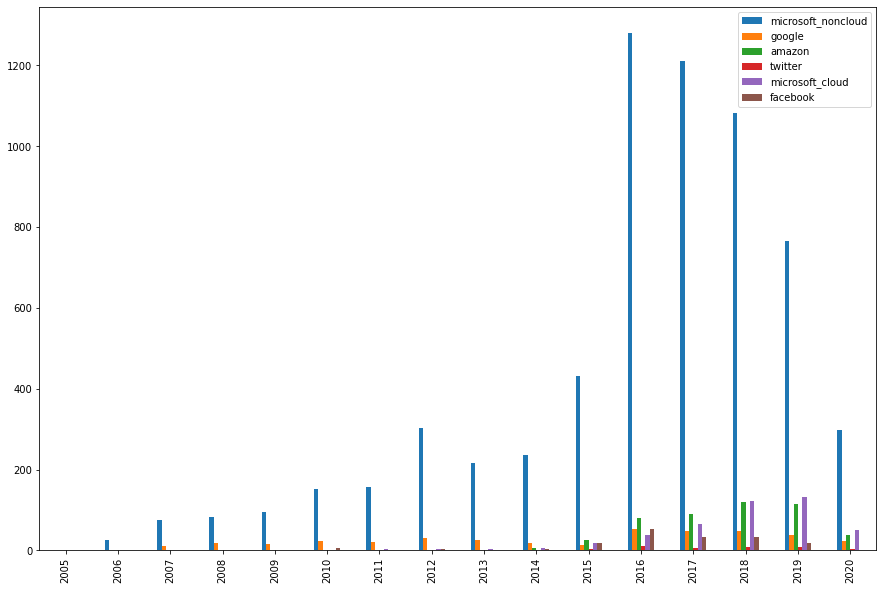

In [11]:
count_df.plot.bar(figsize=(15, 10))

In [12]:
sum_df = pd.DataFrame(
    {k: list(map(lambda x: x['sum'], v)) for k, v in contracts_by_year.items()},
    index=years
)

<AxesSubplot:>

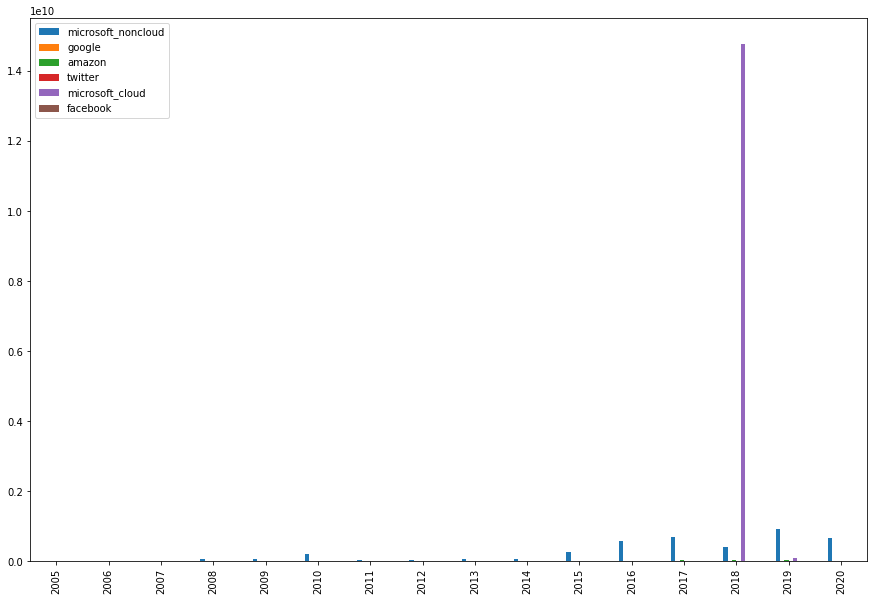

In [13]:
sum_df.plot.bar(figsize=(15, 10))

In [14]:

sum_df.to_csv('./csv/summary_by_year.csv')
sum_df

,microsoft_noncloud,google,amazon,twitter,microsoft_cloud,facebook
2005,9.634400e+02,0.00,0.00,0.00,0.000000e+00,0.00
2006,7.497767e+05,0.00,0.00,0.00,0.000000e+00,0.00
2007,6.761803e+06,464199.75,0.00,0.00,0.000000e+00,0.00
2008,8.166116e+07,1357070.33,0.00,0.00,0.000000e+00,0.00
2009,6.974172e+07,843995.70,0.00,0.00,0.000000e+00,0.00
2010,2.243728e+08,1058042.57,0.00,0.00,0.000000e+00,84479.12
2011,3.636526e+07,1145236.84,5016.90,0.00,0.000000e+00,8448.00
2012,5.213577e+07,2113047.99,0.00,0.00,6.302807e+04,8800.00
2013,7.826378e+07,2981985.59,719076.27,0.00,2.287780e+05,0.00
2014,8.141617e+07,723006.33,288093.37,0.00,4.115055e+05,1320.00


In [15]:
def group_by_agency_and_year(contracts):
    results = {}
    
    get_contract_year = lambda x: x['signed_date'][0:4]
    get_agency_name = lambda x: x['agency_normalized']

    for a in ['DHS', 'Defense', 'Justice', 'State', 'Other']:
        agency_contracts = list(filter(lambda x: get_agency_name(x) == a, contracts))
        agency_year_summaries = []
        agency_year_lookup = {}
        
        for year, year_group in itertools.groupby(sorted(agency_contracts, key=get_contract_year), get_contract_year):
            l = list(year_group)
            agency_year_lookup[year] = { "count": len(l), "sum": sum_passthrough_amount(l) }             

        for year in map(str, years):
            if year in agency_year_lookup:
                agency_year_summaries.append(agency_year_lookup[year])
            else:
                agency_year_summaries.append({"count": 0, "sum": 0})
    
        results[a] = agency_year_summaries
        
    return results  


# CONTRACTS_BY_AGENCY = {}


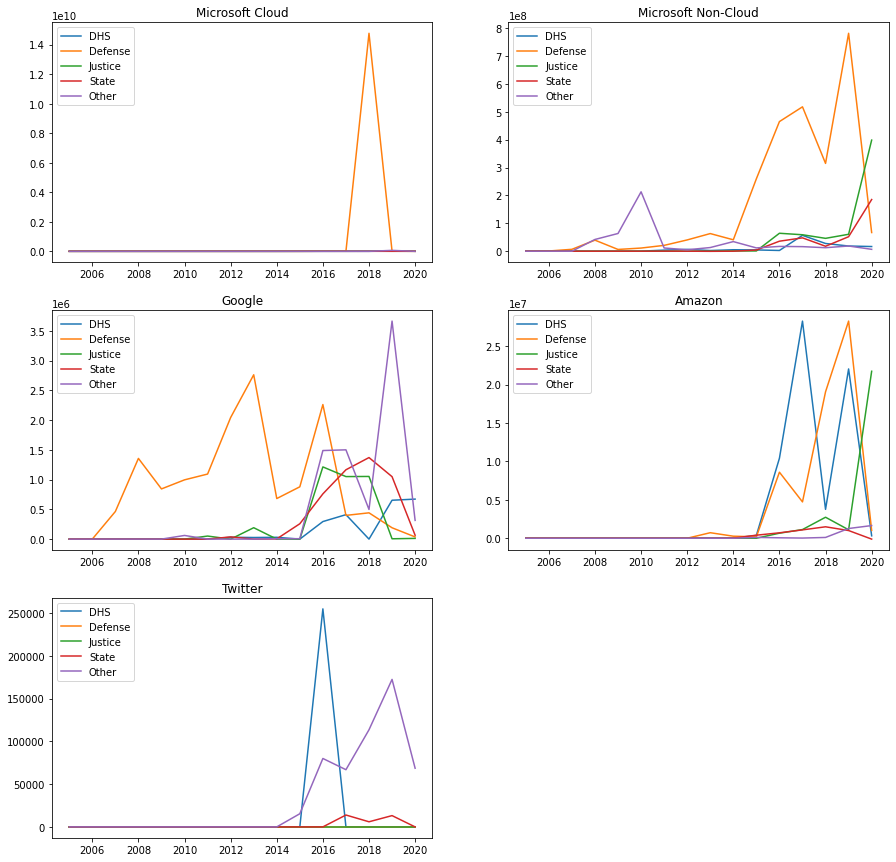

In [16]:
def df_for_key(results, key='sum'):
    data = { k: [ x[key] for x in v] for k, v in results.items()}
    return pd.DataFrame(data, index=years)


for company, contractcs in CONTRACTS.items():
    df_for_key(group_by_agency_and_year(contracts)).to_csv(f"./csv/{company}_group_by_agency.csv")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

df_for_key(group_by_agency_and_year(CONTRACTS['microsoft_cloud'])).plot(ax=axes[0,0])    
axes[0,0].set_title('Microsoft Cloud')

df_for_key(group_by_agency_and_year(CONTRACTS['microsoft_noncloud'])).plot(ax=axes[0,1])    
axes[0,1].set_title('Microsoft Non-Cloud')

df_for_key(group_by_agency_and_year(CONTRACTS['google'])).plot(ax=axes[1,0])    
axes[1,0].set_title('Google')

df_for_key(group_by_agency_and_year(CONTRACTS['amazon'])).plot(ax=axes[1,1])    
axes[1,1].set_title('Amazon')

df_for_key(group_by_agency_and_year(CONTRACTS['twitter'])).plot(ax=axes[2,0])    
axes[2,0].set_title('Twitter')

fig.delaxes(axes[2,1])

## Direct Contracts

In [17]:
# Downloads contract json files and loads it into DIRECT

if not os.path.exists("data/direct"):
    os.makedirs("data/direct")

for company, url in {
    "microsoft": "https://techinquiry.org/explorer/api/awards?vendor=microsoft%20corporation",
    "amazon": "https://techinquiry.org/explorer/api/awards?vendor=amazon.com%2C%20inc.",
    "google": "https://techinquiry.org/explorer/api/awards?vendor=alphabet%20inc."  
}.items():
    path = os.path.join('./data/direct', f"{company}.json")

    if not os.path.isfile(path):
        urllib.request.urlretrieve(url, path)

DIRECT = {}

for path in glob.glob('./data/direct/*.json'):
    company_name = os.path.splitext(os.path.basename(path))[0]
    
    with open(path, 'r') as f:
        DIRECT[company_name] = json.load(f)['filings']
  

In [18]:
DIRECT['google']

[{'id': 210242646,
  'title': 'PURCHASE ORDER 95170020P0104 (P00004) awarded to GOOGLE LLC, was modified for the amount of -$10,421.24',
  'fpds_link': 'https://www.fpds.gov/ezsearch/search.do?s=FPDS&indexName=awardfull&templateName=1.4.4&q=95170020P0104+9568+',
  'contracting_office_agency': 'united states agency for global media, bbg; united states agency for global media, bbg',
  'contracting_office': 'office of contracts',
  'requesting_office_agency': 'united states agency for global media, bbg; united states agency for global media, bbg',
  'requesting_office': 'voa director office',
  'contract_action_type': 'purchase order',
  'vendor': 'google llc',
  'duns': 60902413,
  'signed_date': '2021-06-09T04:00:00.000Z',
  'effective_date': '2020-04-30T04:00:00.000Z',
  'modified_date': None,
  'obligated_amount': '-10421.24',
  'base_and_exercised_options_value': '-10421.24',
  'base_and_all_options_value': '-10421.24',
  'total_obligated_amount': '188728.76',
  'total_base_and_exerc